# Preprocessing

In [258]:
import pandas as pd
import numpy as np
import re
import datetime
from os.path import exists
from geopy.geocoders import Nominatim
import folium
import json
import requests
import nltk
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.parsing.preprocessing import STOPWORDS
import pprint
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import PlaintextCorpusReader
from nltk import sent_tokenize,word_tokenize 
from itertools import chain
import matplotlib.pyplot as plt
from random import shuffle
import statsmodels.formula.api as smf
from statsmodels.api import datasets
import seaborn as sns
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adrie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Now that the data has been scraped, we can take the data from all the cities we scraped and put them all together into one single dataframe.

In [259]:
places_raw = pd.read_excel('places.xlsx', header=None)
places = places_raw[0].values

index=0
cities_scraped = []
for city in places:
    if city not in cities_scraped:
        if exists('data_craigslist'+str(city)+'.csv'):
            cities_scraped.append(city)
            if index == 0:
                df = pd.read_csv('data_craigslist'+str(city)+'.csv').drop(columns=['Unnamed: 0'])
                index += 1
            else:
                df = pd.concat([df, pd.read_csv('data_craigslist'+str(city)+'.csv').drop(columns=['Unnamed: 0'])], axis=0, ignore_index=True)

In [260]:
# Gets rid of the rows where we don't have any features
new_index = []
for ind in df.index:
    try:
        if df.loc[ind].count() >= 7:
            new_index.append(ind)
    except:
        pass

df = df.loc[new_index].reset_index(drop=True)

In [261]:
df.columns

Index(['Price', 'Location', 'URL', 'Date', 'Title', 'num image', 'text',
       'condition', 'make / manufacturer', 'model name / number',
       'bicycle frame material', 'bicycle type', 'brake type',
       'electric assist', 'frame size', 'handlebar type', 'suspension',
       'wheel size', 'size / dimensions', 'serial number', 'part type',
       'paint color', 'year manufactured', 'engine hours (total)',
       'length overall (LOA)', 'propulsion type'],
      dtype='object')

In [262]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5658 entries, 0 to 5657
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Price                   5658 non-null   float64
 1   Location                5658 non-null   object 
 2   URL                     5658 non-null   object 
 3   Date                    5658 non-null   object 
 4   Title                   5658 non-null   object 
 5   num image               5658 non-null   int64  
 6   text                    5658 non-null   object 
 7   condition               2598 non-null   object 
 8   make / manufacturer     2259 non-null   object 
 9   model name / number     1594 non-null   object 
 10  bicycle frame material  2186 non-null   object 
 11  bicycle type            2186 non-null   object 
 12  brake type              828 non-null    object 
 13  electric assist         565 non-null    object 
 14  frame size              2060 non-null   

## Cleaning

Let's now go through every column and standardize the features. Because users fill these features by hand, they can type-in many different answers and we have to make sure they all stay consistent.

In [263]:
print(df['bicycle frame material'].unique())

[nan ' aluminum' ' alloy' ' other/unknown' ' steel' ' carbon fiber'
 ' titanium' ' composite' ' scandium']


In [264]:
def fix_bfm(x):
    if pd.isna(x) or x.strip() == 'other/unknown':
        return 'unknown'
    else:
        return x.strip()

df['bicycle frame material'] = df['bicycle frame material'].apply(fix_bfm)

In [265]:
print(df['bicycle frame material'].unique())

['unknown' 'aluminum' 'alloy' 'steel' 'carbon fiber' 'titanium'
 'composite' 'scandium']


In [266]:
df['bicycle type'].unique()

array([nan, ' mountain', ' other', ' kids', ' hybrid/comfort', ' cruiser',
       ' bmx', ' road', ' unicycle', ' folding', ' gravel',
       ' recumbent/trike', ' cyclocross', ' tandem', ' cargo/pedicab',
       ' track'], dtype=object)

In [267]:
def fix_bt(x):
    if pd.isna(x) or x.strip() == 'other':
        return 'unknown'
    else:
        return x.strip()

df['bicycle type'] = df['bicycle type'].apply(fix_bt)

In [268]:
df['bicycle type'].unique()

array(['unknown', 'mountain', 'kids', 'hybrid/comfort', 'cruiser', 'bmx',
       'road', 'unicycle', 'folding', 'gravel', 'recumbent/trike',
       'cyclocross', 'tandem', 'cargo/pedicab', 'track'], dtype=object)

In [269]:
df['frame size'].unique()

array([nan, ' Medium', ' Large', ' 26 inch', ' Fits most bikes!',
       ' 12” wheels', ' 18', ' 0', ' 8"', ' 24”', ' All', ' 26" and 24"',
       ' medium', ' 19.5', ' any', ' 56cm', ' 54 cm, medium', ' 60cm',
       ' All sizes', ' 16 inch', ' unknown', ' N/A', ' Unknown', ' None',
       ' 15 inch', ' 60 cm', ' 18 "', ' 19in', ' 26 in',
       ' 42x40x10 inches', ' 52 cm', ' Any size', ' 15"', ' 18.5”',
       ' n/a', ' Kids size', ' 50cm', " Women's Medium", ' 20" wheels',
       ' 26in.', ' Medium/Large', ' small', ' Small', " don't reall know",
       ' 54cm medium17.5', ' Adult', ' good size', ' MEDIUM TO LARGE',
       ' 27"', ' 20"', ' XXL', ' 65cm', ' 18.25 in (46.35 cm)', ' 20',
       ' child size', ' 49 to 63 cm', ' 26”', ' 16', ' 26"', " 26'",
       ' 16”, 12”', ' About 16 inches.', ' ?', ' 24"', ' .', ' 26',
       ' 17 inch, 25 inch, etc.', ' 17.5 in  54 in',
       ' Standard Cruiser Size', ' kids', ' see pictures',
       ' 19inches 49cm', ' Heavy-duty 57 cm.', ' 20”

In [270]:
def fix_fs(x):
    if pd.isna(x):
        return 'unknown'
    numbers = re.findall(r'\d+', x)
    if len(numbers) == 0:
        if 'medium' in x.lower():
            return 2
        elif 'large' in x.lower():
            return 3
        elif 'small' in x.lower():
            return 1
        else:
            return 'unknown'
    else:
        if '"' or "'" or 'inches' or 'inch' or 'in' in x.lower(): #it's in inches
            size = float(numbers[0]) # assume it's the first number
            if size < 16:
                return 1
            if size > 19:
                return 3
            else:
                return 2
        else: #cm
            size = float(numbers[0])
            if size < 53:
                return 1
            if size > 56:
                return 3
            else:
                return 2

df['frame size'] = df['frame size'].apply(fix_fs)

In [271]:
df['frame size'].unique()

array(['unknown', 2, 3, 1], dtype=object)

In [272]:
df['suspension'].unique()

array([nan, ' suspension fork (hardtail)', ' none (rigid)',
       ' other/unknown', ' frame and fork (full suspension)'],
      dtype=object)

In [273]:
def fix_s(x):
    if pd.isna(x):
        return 0
    if 'fork' in x.lower():
        return 1
    else:
        return 0

df['suspension'] = df['suspension'].apply(fix_s)

In [274]:
df['suspension'].unique()

array([0, 1], dtype=int64)

In [275]:
df['wheel size'].unique()

array([nan, ' 26 in', ' other/unknown', ' 12 in', ' 24 in', ' 20 in',
       ' 27 in', ' 700C', ' 25 in', ' 29 in', ' 14 in', ' 16 in',
       ' 10 in', ' 650B', ' 18 in', ' 27.5 in', ' 28 in', ' 26.5 in',
       ' 650C'], dtype=object)

In [276]:
def fix_ws(x):
    if pd.isna(x):
        return 'unknown'
    if '700' in x.strip():
        return 29
    if '650' in x.strip():
        return 26
    numbers = re.findall(r'\d+', x)
    if len(numbers)==0:
        return 'unknown'
    else:
        if int(numbers[0]) > 30:
            return 'unknown'
        else:
            return int(numbers[0])

df['wheel size'] = df['wheel size'].apply(fix_ws)

In [277]:
df['wheel size'].unique()

array(['unknown', 26, 12, 24, 20, 27, 29, 25, 14, 16, 10, 18, 28],
      dtype=object)

In [278]:
df['condition'].unique()

array([nan, ' excellent', ' new', ' good', ' salvage', ' like new',
       ' fair'], dtype=object)

In [279]:
def fix_c(x):
    if pd.isna(x):
        return 'unknown'
    x = str(x)
    if 'good' in x:
        return 3
    if 'fair' in x:
        return 2
    if 'salvage' in x or 'poor' in x:
        return 1
    if 'new' or 'excellent' in x:
        return 4
    
    return 'unknown'


df['condition'] = df['condition'].apply(fix_c)

In [280]:
df['condition'].unique()

array(['unknown', 4, 3, 1, 2], dtype=object)

In [281]:
df['electric assist'].unique()

array([nan, ' none', ' other', ' throttle', ' pedal assist'], dtype=object)

In [282]:
def fix_ea(x):
    if pd.isna(x):
        return 0
    x = str(x)
    if 'other' in x or 'none' in x:
        return 0
    return 1

df['electric assist'] = df['electric assist'].apply(fix_ea)

In [283]:
df['electric assist'].unique()

array([0, 1], dtype=int64)

In [284]:
df['make / manufacturer'].unique()

array([nan, ' Thule', ' BodyKore', ' Trek', ' Huffy', ' Diamondback',
       ' joystar', ' critical', ' huffy', ' SE Bikes', ' Saris',
       ' Royce Union, Huffy', ' Kent', ' Real tree', ' Cyberbike',
       ' all makes', ' NS Bikes', ' Fuji', ' Allen', ' Schwinn', ' Sun',
       ' Marin', ' Sole', ' Specialized', ' Life Fitness, Cybex, Hammer',
       ' Yakima', ' HUSQVARNA', ' Gatormade Trailers', ' roadmaster',
       ' Orbea', ' Bikemate', ' Suzuki', ' Viathon', ' Harley Davidson',
       ' Tony Hawk', ' Scott', ' Stamina', ' central bike', ' Litespeed',
       ' Jamis', ' mongoose', ' Rollfast', ' Giant', ' Windsor',
       ' Coleman', ' Rad Power Bikes', ' Maxxhaul', ' Dynacraft',
       ' grabber', ' Sears, JC Higgins', ' Salsa', ' Rad Power Bike',
       ' BMX', ' Hollywood', ' Triton', ' CUB CADET', ' BASS CAT',
       ' hotwheels', ' Charge Bikes', ' Free Spirit', ' All', ' Gibson',
       ' Bjorn', ' Lamar Trailers', ' Yamaha', ' sixthreezero',
       ' Rock Solid Cargo', '

In [285]:
def fix_mm(x):
    if pd.isna(x) or 'unknown' in x.lower():
        return 0
    return 1

df['make / manufacturer'] = df['make / manufacturer'].apply(fix_mm)

In [286]:
df['make / manufacturer'].unique()

array([0, 1], dtype=int64)

In [287]:
df['model name / number'].unique()

array([nan, ' 961XT Speedway', ' G703', ..., ' Mix', ' Various/mix',
       ' DRT 1.0'], dtype=object)

In [288]:
def fix_mn(x):
    if pd.isna(x) or 'unknown' in x.lower():
        return 0
    return 1

df['model name / number'] = df['model name / number'].apply(fix_mn)

In [289]:
df['model name / number'].unique()

array([0, 1], dtype=int64)

In [290]:
df['brake type'].unique()

array([nan, ' cantilever', ' disc (mechanical)', ' caliper', ' none',
       ' other/unknown', ' coaster', ' disc (hydraulic)', ' gyro/bmx',
       ' u-brakes', ' v-brakes', ' drum', ' hydraulic rim brakes'],
      dtype=object)

In [291]:
def fix_bt(x):
    if pd.isna(x) or 'other/unknown' in x.lower() or 'none' in x.lower():
        return 'unknown'
    else:
        x = str(x)
        if 'hydraulic' in x:
            return 'hydraulic'
        elif 'mechanical' in x:
            return 'mechanical'
        else:
            return 'special'

df['brake type'] = df['brake type'].apply(fix_bt)

In [292]:
df['brake type'].unique()

array(['unknown', 'special', 'mechanical', 'hydraulic'], dtype=object)

In [293]:
df['handlebar type'].unique()

array([nan, ' flat', ' bmx', ' other/unknown', ' drop', ' cruiser',
       ' triathlon', ' riser', ' downhill', ' aero', ' bullhorn'],
      dtype=object)

In [294]:
def fix_ht(x):
    if pd.isna(x) or 'other/unknown' in x:
        return 'unknown'
    else:
        return 'special'

df['handlebar type'] = df['handlebar type'].apply(fix_ht)

In [295]:
df['handlebar type'].unique()

array(['unknown', 'special'], dtype=object)

In [296]:
df['part type'].unique()

array([nan, ' other', ' racks, fenders, bags', ' saddle',
       ' grips, bar ends, tape', ' tires', ' wheels and wheel parts',
       ' crankset, bottom bracket, guards', ' frameset (frame and fork)',
       ' brakes', ' pedals', ' headset, stem, spacers', ' frame only'],
      dtype=object)

In [297]:
def fix_pt(x):
    if pd.isna(x) or 'other' in x.lower():
        return 0
    else:
        return 1

df['part type'] = df['part type'].apply(fix_pt)
# Let's get rid of the listings about parts
df = df.where(df['part type']==0).dropna(how='all').drop(columns=['part type'])

In [298]:
df['size / dimensions'].unique()

array([nan, ' 1 1/4” hitch', ' 26.38 x 12.2 x 13.98',
       ' \u200e42 x 40 x 10 inches', ' 750', ' 56x9.5x4.5',
       ' 4-bike capacity', ' 168" X 86" X 0"', ' 192" X 84" X 0"',
       ' 168" X 83" X 0"', ' 26”', ' 2011---2016', ' 51x 48x30',
       ' 36 Volt 42 Volt 48 Volt', ' S, L, M, XL, XXL', ' See above',
       ' 5\'×17" UNFOLDED', ' 31.5 x 21 x 25.5 in (Interior)',
       ' 125cc 250cc 500cc', ' 8.5 x 28', " Women's size medium", ' 1111',
       ' Large', ' 22', ' na', ' 196cc', ' 9 x 22', ' 7.48 mm',
       ' 2500 sq feet', ' 6 feet', ' 12x5', ' 42', ' 59x32x42in',
       ' 7.5 feet tall approx', ' 5x1x3,12', " Men's Large",
       ' Fully Inspected', ' 41" x 20"', ' X-Large', ' 62"wide',
       ' 7X14X3 16K GN DUMP TRAILER', ' 25 LBS', ' 40’x 7’8”x 79”tall',
       ' 32" x 68" x 74"', ' 20”', ' 3x4', ' 600', ' Holds 4 Bikes', ' ?',
       ' 130/90-16', ' 16 x 5.00', ' 240" X 82" X 0"', ' 144" X 76" X 0"',
       ' 240" X 102" X 0"', ' 432" X 102" X 0"', ' 240" X 83" X 0"',

In [299]:
def fix_sd(x):
    if pd.isna(x):
        return 0
    else:
        return 1

df['size / dimensions'] = df['size / dimensions'].apply(fix_sd)

In [300]:
df['size / dimensions'].unique()

array([0, 1], dtype=int64)

In [301]:
df['paint color'].unique()

array([nan, ' black', ' grey', ' custom', ' white', ' silver', ' brown',
       ' red'], dtype=object)

In [302]:
def fix_pc(x):
    if pd.isna(x):
        return 0
    else:
        return 1

df['paint color'] = df['paint color'].apply(fix_pc)

In [303]:
df['paint color'].unique()

array([0, 1], dtype=int64)

In [304]:
df['serial number'].unique()

array([nan, ' Unknown', ' F1068892', ' N/A', ' EN14872XINGING',
       ' TC19 222501', ' na', ' NSN not needed', ' Model GS32401', ' 000',
       ' 20A16575', ' M5060820', ' RU1F20V0502', ' yes', ' GS62660',
       ' un', ' EB720DO', ' S  / N', ' on request', ' none',
       ' AITPZ29SD6L1G1', ' SNHU07J15066', ' #185', ' F7U42856',
       ' LF201110072', ' ?', ' 01V120067', ' E6EE07509', ' Assorted',
       ' WSBC025068284R', ' 170720', ' 26’', ' M50', ' UUK19C01204', 1.0,
       ' EZ-201304 468', ' 56750N514', ' H92010532', ' PA20301', ' N/n',
       ' 00020002', ' FZ18GY0047', ' Not sure', ' many', ' unknown',
       ' 408 406 7864 cell', ' Var', ' 1960', ' bb1655', ' KAEK23231',
       ' Nome', ' 23-918', ' See Photos', ' EG010897', ' 00012345', ' .',
       ' various', ' Ninja 2021', ' Freestyle', ' ??', ' NA',
       ' WT0406C5218', ' WTU336CT0109R1207', ' N/a', ' 1234567890',
       ' CU5C21B3934', ' see photos'], dtype=object)

In [305]:
def fix_sn(x):
    if pd.isna(x):
        return 0
    elif isinstance(x, float):
        return 1
    else:
        if 'unknown' in x.lower() or 'no' in x.lower() or 'n/' in x.lower():
            return 0
    return 1

df['serial number'] = df['serial number'].apply(fix_sn)

In [306]:
df['serial number'].unique()

array([0, 1], dtype=int64)

In [307]:
df['year manufactured'].unique()

array([  nan, 2022., 2020., 2010., 1975., 2018., 2015., 1979., 2005.,
       2021., 2013., 1987., 1990., 2006., 2004., 2001., 2019., 2012.,
       2017.])

In [308]:
def fix_ym(x):
    if pd.isna(x):
        return 0
    else:
        return 1

df['year manufactured']=df['year manufactured'].apply(fix_ym)

In [309]:
df['year manufactured'].unique()

array([0, 1], dtype=int64)

In [310]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5576 entries, 0 to 5657
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Price                   5576 non-null   float64
 1   Location                5576 non-null   object 
 2   URL                     5576 non-null   object 
 3   Date                    5576 non-null   object 
 4   Title                   5576 non-null   object 
 5   num image               5576 non-null   float64
 6   text                    5576 non-null   object 
 7   condition               5576 non-null   object 
 8   make / manufacturer     5576 non-null   float64
 9   model name / number     5576 non-null   float64
 10  bicycle frame material  5576 non-null   object 
 11  bicycle type            5576 non-null   object 
 12  brake type              5576 non-null   object 
 13  electric assist         5576 non-null   float64
 14  frame size              5576 non-null   

In [311]:
df.columns

Index(['Price', 'Location', 'URL', 'Date', 'Title', 'num image', 'text',
       'condition', 'make / manufacturer', 'model name / number',
       'bicycle frame material', 'bicycle type', 'brake type',
       'electric assist', 'frame size', 'handlebar type', 'suspension',
       'wheel size', 'size / dimensions', 'serial number', 'paint color',
       'year manufactured', 'engine hours (total)', 'length overall (LOA)',
       'propulsion type'],
      dtype='object')

In [312]:
# These 3 columns have less than 0.1% of data available so we'll drop them
df = df.drop(columns=['length overall (LOA)', 'propulsion type', 'engine hours (total)'])

In [313]:
df.columns = [column.replace('/', '').lower().strip().replace(' ', '') for column in df.columns]

In [314]:
df.columns

Index(['price', 'location', 'url', 'date', 'title', 'numimage', 'text',
       'condition', 'makemanufacturer', 'modelnamenumber',
       'bicycleframematerial', 'bicycletype', 'braketype', 'electricassist',
       'framesize', 'handlebartype', 'suspension', 'wheelsize',
       'sizedimensions', 'serialnumber', 'paintcolor', 'yearmanufactured'],
      dtype='object')

Let's add the number of days since the listing was posted on the website as a feature.

In [315]:
df['days'] = [(datetime.datetime.today()-datetime.datetime.strptime(date_, "%Y-%m-%d %H:%M")).days for date_ in df['date']]

# Missing values analysis

How many of each features are we missing, and can we find these values within the text (body of the listing)?

In [316]:
important_attributes = ['price', 'condition', 'numimage', 'bicycleframematerial', 'bicycletype', 'braketype', 'framesize', 'handlebartype','wheelsize']

for column in important_attributes:
    df_values = pd.DataFrame(df.groupby([column]).size())
    display(df_values)

,0
price,
1.0,245
2.0,2
4.0,1
5.0,22
7.0,2
...,...
445522.0,1
595000.0,1
999992.0,1


,0
condition,
1,19
2,95
3,552
4,1859
unknown,3051


,0
numimage,
0.0,991
2.0,591
3.0,508
4.0,521
5.0,397
6.0,384
7.0,328
8.0,229
9.0,190


,0
bicycleframematerial,
alloy,209
aluminum,751
carbon fiber,112
composite,15
scandium,1
steel,578
titanium,12
unknown,3898


,0
bicycletype,
bmx,237
cargo/pedicab,8
cruiser,222
cyclocross,7
folding,50
gravel,32
hybrid/comfort,161
kids,245
mountain,525


,0
braketype,
hydraulic,232
mechanical,116
special,378
unknown,4850


,0
framesize,
1,241
2,538
3,744
unknown,4053


,0
handlebartype,
special,487
unknown,5089


,0
wheelsize,
10,30
12,57
14,31
16,93
18,41
20,264
24,124
25,16
26,524


In [317]:
def loss_analysis(df):
    unknown_dic = dict()
    n=len(df)
    for column in important_attributes:
        df_values = pd.DataFrame(df.groupby([column]).size())
        if column == 'price':
            unknown = len(df[(df['price']<10) | (df['price']>300)])
            unknown_dic[column]=[unknown,round(unknown/n*100,1)]
        try:
            unknown = int(df_values.loc['unknown'])
        except:
            pass
        else:
            unknown_dic[column]=[unknown,round(unknown/n*100,1)]
    df_unknown = pd.DataFrame(data=unknown_dic,index=['Unknowns','% of Unknowns']).transpose()
    return df_unknown

In [318]:
loss_analysis(df)

,Unknowns,% of Unknowns
price,3143.0,56.4
condition,3051.0,54.7
bicycleframematerial,3898.0,69.9
bicycletype,3769.0,67.6
braketype,4850.0,87.0
framesize,4053.0,72.7
handlebartype,5089.0,91.3
wheelsize,3888.0,69.7


## Let's look into the text

In [319]:
def retrieve_condition_from_txt(text):
    sentences = re.compile(r'([A-Z][^\.!?]*[\.!?])', re.M).findall(text)
    for sentence in sentences:
        if 'condition' in sentence:
            return sentence

def fix_condition_from_txt(text,condition):
    if condition != 'unknown':
        return condition
    else:
        sentence = retrieve_condition_from_txt(text)
        if sentence is None:
            return 'unknown'
        else:
            sentence = sentence.lower()
            if 'very good' in sentence or 'excellent' in sentence or 'new' in sentence or 'very nice' in sentence:
                return str(4)
            if 'good used condition' in sentence or 'good' in sentence or 'very pretty' in sentence or 'great' in sentence:
                return str(3)
            if 'nice' in sentence or 'fair' in sentence:
                return str(2)
            if 'poor' in sentence or 'salvage' in sentence:
                return str(1)
            else:
                return 'unknown'

before = loss_analysis(df).loc['condition','Unknowns']
df['condition'] = df.apply(lambda x: fix_condition_from_txt(x['text'],x['condition']), axis=1)
after = loss_analysis(df).loc['condition','Unknowns']
print("+ "+ str(int(before-after)) + " data for 'condition' after using fix_condition_from_txt.")


+ 354 data for 'condition' after using fix_condition_from_txt.


In [320]:
def fix_material_from_txt(text, material):
    if material != 'unknown':
        return material
    else:
        if 'aluminum' in text:
            return 'aluminum'
        if 'alloy' in text:
            return 'alloy'
        if 'steel' in text:
            return 'steel'
        if 'carbon' in text:
            return 'carbon fiber'
        if 'titanium' in text:
            return 'titanium'
        if 'composite' in text:
            return 'composite'
        if 'scandium' in text:
            return 'scandium'
        else:
            return 'unknown'


before = loss_analysis(df).loc['bicycleframematerial','Unknowns']
df['bicycleframematerial'] = df.apply(lambda x: fix_material_from_txt(x['text'],x['bicycleframematerial']), axis=1)
after = loss_analysis(df).loc['bicycleframematerial','Unknowns']
print("+ "+ str(int(before-after)) + " data for 'bicycleframematerial' after using fix_material_from_txt.")

+ 523 data for 'bicycleframematerial' after using fix_material_from_txt.


In [321]:
def fix_bicycletype_from_txt(text,bicycletype):
    if bicycletype != 'unknown':
        return bicycletype
    else:
        if 'mountain' in text:
            return 'mountain'
        if 'kids' in text:
            return 'kids'
        if 'hybrid' in text:
            return 'hybrid/comfort'
        if 'comfort' in text:
            return 'hybrid/comfort'
        if 'cruiser' in text:
            return 'cruiser'
        if 'bmx' in text:
            return 'bmx'
        if 'road' in text:
            return 'road'
        if 'unicycle' in text:
            return 'unicycle'
        if 'folding' in text:
            return 'folding'
        if 'gravel' in text:
            return 'gravel'
        if 'recumbent' in text:
            return 'recumbent/trike'
        if 'cyclocross' in text:
            return 'cyclocross'
        if 'tandem' in text:
            return 'tandem'
        if 'track' in text:
            return 'track'
        if 'cargo' in text:
            return 'cargo/pedicab'
        if 'pedicab' in text:
            return 'cargo/pedicab'
        else:
            return 'unknown'

before = loss_analysis(df).loc['bicycletype','Unknowns']
df['bicycletype'] = df.apply(lambda x: fix_bicycletype_from_txt(x['text'],x['bicycletype']), axis=1)
after = loss_analysis(df).loc['bicycletype','Unknowns']
print("+ "+ str(int(before-after)) + " data for 'bicycletype' after using fix_bicycletype_from_txt.")

+ 1278 data for 'bicycletype' after using fix_bicycletype_from_txt.


In [322]:
def fix_braketype_from_txt(text,braketype):
    if braketype != 'unknown':
        return braketype
    else:
        if 'mechanical' in text:
            return 'mechanical'
        if 'hydraulic' in text:
            return 'hydraulic'
        else:
            return 'unknown'

before = loss_analysis(df).loc['braketype','Unknowns']
df['braketype'] = df.apply(lambda x: fix_braketype_from_txt(x['text'],x['braketype']), axis=1)
after = loss_analysis(df).loc['braketype','Unknowns']
print("+ "+ str(int(before-after)) + " data for 'braketype' after using fix_braketype_from_txt.")

+ 157 data for 'braketype' after using fix_braketype_from_txt.


In [323]:
loss_analysis(df)

,Unknowns,% of Unknowns
price,3143.0,56.4
condition,2697.0,48.4
bicycleframematerial,3375.0,60.5
bicycletype,2491.0,44.7
braketype,4693.0,84.2
framesize,4053.0,72.7
handlebartype,5089.0,91.3
wheelsize,3888.0,69.7


# Price preprocessing

It happens pretty often that people set unrealistic prices, of $1 for example. Sometimes, people don't sell bikes too, they sell motorcycles, which are much more extensive. The goal of this part is to get rid of these listings, and if possible, to retrieve the real price from the text.

In [324]:
df.price.describe()

count    5.576000e+03
mean     1.839986e+04
std      8.917734e+05
min      1.000000e+00
25%      8.000000e+01
50%      3.500000e+02
75%      2.900000e+03
max      6.543290e+07
Name: price, dtype: float64

The standard deviation is extremely high, let's look carefully into the listings with a price greater than $3000 or smaller than $10.

In [325]:
df_filter = df[(df['price']>3000) | (df['price']<10)]
print(f'The number of incoherent announces regarding their price is: ',len(df_filter))

The number of incoherent announces regarding their price is:  1629


For example, you can see below the discrepancy between the listed price and the one we can find in the text:

For one listing we have:

- Price: $ 1.0
- Description:  SCHWINN CLASSIC BIKES, SELLING AS A PAIR. ONLY $100 FOR BOTH!

In [326]:
index_list = df_filter.index
index_list_final = list()
new_price_list = list()

for i in df.index:
  if i in df_filter.index:
    new_price_int = list()
    try:
      new_price = re.findall('\$(\x20?\d+(?:[,]\d{0,3})?)', df_filter['text'][i])
      for j in new_price:
        new_price_int.append(int(j.replace(',','')))
      if new_price_int == []:
        new_price = float('Nan')
        new_price_list.append(new_price)
        index_list_final.append(i)
      else:
        new_price_list.append(int(sum(new_price_int)/len(new_price_int)))
        index_list_final.append(i)
    except:
      #If there is no match, we replace the price value by NaN to eliminate them easily from our database
      new_price_list.append(float('Nan'))
      index_list_final.append(i)
  else:
    new_price_list.append(df['price'][i])
    index_list_final.append(i)

df_new_price = pd.DataFrame({'price' : new_price_list, 'Index':index_list_final})
df_new_price.set_index('Index', inplace = True)
df_new_price.head()

,price
Index,
0,1000.0
1,NaN
2,2995.0
3,30.0
4,112.0


Let's add back the new prices we found:

In [327]:
df['price'] = df_new_price['price']

In [328]:
df.price.describe()

count      4775.000000
mean       2170.945759
std        8718.782118
min           0.000000
25%          80.000000
50%         289.000000
75%        1498.000000
max      317422.000000
Name: price, dtype: float64

In [329]:
df = df[(df['price']<=3000) & (df['price']>=10)]

In [330]:
df.price.describe()

count    4231.000000
mean      602.531553
std       775.123539
min        10.000000
25%        72.500000
50%       200.000000
75%       899.000000
max      3000.000000
Name: price, dtype: float64

We can see above that the standard deviation is now much smaller, and that the values seem more realistic for bikes.

# Let us get rid of the non-bikes listings by finding topics within text

In [331]:
#We will use the description and the title of the annouce to get the topic

df_info = df[['text','title']]

bike_desc_list = list()
for i in df_info.index:
    bike_desc_list.append(df_info['title'][i]+df_info['text'][i])

for i in range(len(bike_desc_list)):
    desc = bike_desc_list[i]
    sents = sent_tokenize(desc)
    for j in range(len(sents)):
        sent = sents[j]
        sent = sent.strip().replace('\n','')
        sents[j] = sent
    bike_desc_list[i] = '. '.join(sents)

texts = [[word for word in desc.lower().split()
        if word not in STOPWORDS and word.isalpha() and not word.lower() == 'slate'] #We only keep alpha values
        for desc in bike_desc_list]

dictionary = corpora.Dictionary(texts) #(word_id,word) pairs
corpus = [dictionary.doc2bow(text) for text in texts] #(word_id,freq) pairs by sentence

In [332]:
#Set parameters
num_topics = 3 #The number of topics that should be generated
passes = 10

lda = LdaModel(corpus,
              id2word=dictionary,
              num_topics=num_topics,
              passes=passes)

pp = pprint.PrettyPrinter(indent=4)
pp.pprint(lda.print_topics(num_words=8))

lda.show_topic(2)

[   (   0,
        '0.013*"dirt" + 0.012*"bike" + 0.006*"go" + 0.006*"electric" + '
        '0.006*"porsche" + 0.005*"hitch" + 0.004*"new" + 0.004*"kids"'),
    (   1,
        '0.022*"bike" + 0.015*"bikes" + 0.010*"new" + 0.009*"road" + '
        '0.008*"rack" + 0.006*"equipment" + 0.005*"custom" + 0.005*"will"'),
    (   2,
        '0.145*"trailers" + 0.084*"motorcycle" + 0.059*"camping" + 0.045*"car" '
        '+ 0.036*"dolly" + 0.032*"sale" + 0.031*"trailer" + 0.029*"atv"')]


[('trailers', 0.14471506),
 ('motorcycle', 0.084309876),
 ('camping', 0.058880307),
 ('car', 0.04515391),
 ('dolly', 0.035664044),
 ('sale', 0.032139555),
 ('trailer', 0.030709196),
 ('atv', 0.028907364),
 ('used', 0.025826016),
 ('tow', 0.015520386)]

In [333]:
lda_corpus = lda[corpus]

# Find the threshold, let's set the threshold to be 1/#clusters,
# To prove that the threshold is sane, we average the sum of all probabilities:
scores = list(chain(*[[score for topic_id,score in topic] \
                      for topic in [doc for doc in lda_corpus]]))
threshold = sum(scores)/len(scores)
print(threshold)
index_cluster1=[]
index_cluster2=[]
index_cluster3=[]
counter = -1
for i,j in zip(lda_corpus,bike_desc_list):
    counter+=1
    for size in range(len(i)):
        if i[size][1] > threshold:
            if i[size][0] == 0:
                index_cluster1.append(counter)
            elif i[size][0] == 1:
                index_cluster2.append(counter)
            elif i[size][0] == 2:
                index_cluster3.append(counter)

0.40034012895085946


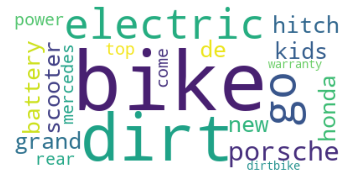

In [334]:
#We create word clouds to know which cluster corresponds to which topics

def draw_wordcloud(lda,topicnum,min_size=0,STOPWORDS=[]):
    word_list=[]
    prob_total = 0
    for word,prob in lda.show_topic(topicnum,topn=50):
        prob_total +=prob
    for word,prob in lda.show_topic(topicnum,topn=50):
        if word in STOPWORDS or  len(word) < min_size:
            continue
        freq = int(prob/prob_total*100)
        alist=[word]
        word_list.extend(alist*freq)
        
    %matplotlib inline
    shuffle(word_list)
    text = ' '.join(word_list)
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',max_words=20).generate(text)

    plt.axis('off')
    plt.imshow(wordcloud)

    return word_list

word_list_1 = draw_wordcloud(lda,0)

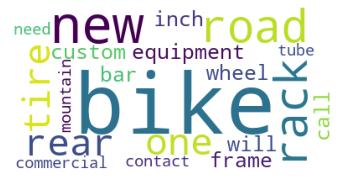

In [335]:
word_list_2 = draw_wordcloud(lda,1)

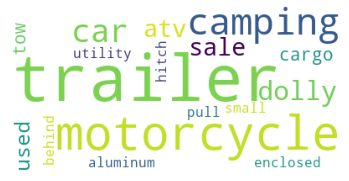

In [336]:
word_list_3 = draw_wordcloud(lda,2)

In [337]:
def count_bike(list_words):
    count=0
    for word in list_words:
        if word == 'bike' or word == 'bikes':
            count+=1
    return count

In [338]:
word_lists = [word_list_1, word_list_2, word_list_3]

index_not_bikes = []
for i, words in enumerate(word_lists):
    if count_bike(words) < 3:
        if i == 0:
            index_not_bikes += index_cluster1
        elif i == 1:
            index_not_bikes += index_cluster2
        elif i == 2:
            index_not_bikes += index_cluster3

print(f'We are getting rid of {len(index_not_bikes)} rows.')
print(f'Cluster 1 has {len(index_cluster1)} rows.')
print(f'Cluster 2 has {len(index_cluster2)} rows.')
print(f'Cluster 3 has {len(index_cluster3)} rows.')

We are getting rid of 203 rows.
Cluster 1 has 588 rows.
Cluster 1 has 3668 rows.
Cluster 1 has 203 rows.


In [339]:
# We delete the annouces which do not correspond to bike annouces for sure
df = df.reset_index(drop=True)

for i in index_not_bikes:
    df.drop(index=i, inplace = True, errors='ignore')
df.reset_index(inplace = True)
df.drop(columns = 'index', inplace= True)

In [340]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4028 entries, 0 to 4027
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   price                 4028 non-null   float64
 1   location              4028 non-null   object 
 2   url                   4028 non-null   object 
 3   date                  4028 non-null   object 
 4   title                 4028 non-null   object 
 5   numimage              4028 non-null   float64
 6   text                  4028 non-null   object 
 7   condition             4028 non-null   object 
 8   makemanufacturer      4028 non-null   float64
 9   modelnamenumber       4028 non-null   float64
 10  bicycleframematerial  4028 non-null   object 
 11  bicycletype           4028 non-null   object 
 12  braketype             4028 non-null   object 
 13  electricassist        4028 non-null   float64
 14  framesize             4028 non-null   object 
 15  handlebartype        

# Analysis and visualization

Let's visualize the average price per state.

In [341]:
def preprocess_cities(cities):
    for i, city in enumerate(cities):
        if city == 'newyork':
            cities[i] = 'new york'
        elif city == 'newjersey':
            cities[i] = 'new jersey'
        elif city == 'lasvegas':
            cities[i] = 'las vegas'
        elif city == 'longisland':
            cities[i] = 'long island'
        elif city == 'losangeles':
            cities[i] = 'los angeles'
        elif city == 'saltlakecity':
            cities[i] = 'salt lake city'
        elif city == 'sfbay':
            cities[i] = 'san francisco'
    return cities

def preprocess_back_cities(cities):
    for i, city in enumerate(cities):
        if city == 'new york':
            cities[i] = 'newyork'
        elif city == 'new jersey':
            cities[i] = 'newjersey'
        elif city == 'las vegas':
            cities[i] = 'lasvegas'
        elif city == 'long island':
            cities[i] = 'longisland'
        elif city == 'los angeles':
            cities[i] = 'losangeles'
        elif city == 'salt lake city':
            cities[i] = 'saltlakecity'
        elif city == 'san francisco':
            cities[i] = 'sfbay'
    return cities

all_cities = preprocess_cities(df['location'].unique())

In [342]:
states= ['Alabama', 'Alaska', 'Arizona', 'Arkansas','California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois'
,'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri'
,'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma'
,'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']

codes = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE'
,'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']

state_codes = {}
for i, state in enumerate(states):
    state_codes[state] = codes[i]

In [343]:
def find_states(all_cities):
    """Takes a list of cities and returns a dictionary of the cities and their corresponding state."""
    geolocator = Nominatim(user_agent="location script")
    
    dict_states = {}
    
    for city in all_cities:

        location = str(geolocator.geocode(city))
        for state in states:
            if state.lower() in location.lower():
                dict_states[city] = state_codes[state]
        
    return dict_states #finally retruns the dict 

city_states = find_states(all_cities)

states_cities = {}
for key in city_states:
    if city_states[key] not in states_cities:
        states_cities[city_states[key]] = [key]
    else:
        states_cities[city_states[key]].append(key)

In [344]:
def find_mean_price_per_state(state_cities_dict):

    price_per_state = {}

    for state in state_cities_dict:

        price_per_state[state] = []

        list_of_cities_not_ready = state_cities_dict[state]
        list_of_cities = preprocess_back_cities(list_of_cities_not_ready)

        for city in list_of_cities:
            price_per_state[state].append(df.where(df['location']==city).dropna()['price'].mean())

        price_per_state[state] = np.mean(price_per_state[state])
    
    return price_per_state

mean_price_data = pd.DataFrame.from_dict(find_mean_price_per_state(states_cities), 'index', columns=['mean price']).reset_index().rename(columns={'index':'state'})
mean_price_data.head()

,state,mean price
0,AL,599.040480
1,IN,564.725000
2,AK,501.662631
3,AZ,665.926665
4,NM,661.632653


In [345]:
us_states_url_indata = {}
data_url = ("https://raw.githubusercontent.com/python-visualization/folium/master/examples/data")
us_states_url = f"{data_url}/us-states.json"
t = requests.get(us_states_url).content
geodict = json.loads(t)
us_states_url_indata['type'] = geodict['type']
us_states_url_indata['features'] = []
for state_dic in geodict['features']:
    if state_dic['id'] in mean_price_data['state'].values:
        us_states_url_indata['features'].append(state_dic)

In [346]:
m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=us_states_url_indata,
    name='choropleth',
    data=mean_price_data,
    columns=['state', 'mean price'],
    key_on='feature.id',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Mean price'
).add_to(m)

m

# Feature Selection

## Explainability: Benjamini Hochberg procedure & p-values

In [348]:
df = df.replace(to_replace='unknown', value=np.nan)

In [349]:
important_attributes = ['numimage','condition', 'bicycleframematerial', 'bicycletype','braketype',
                        'electricassist', 'framesize', 'handlebartype','suspension','wheelsize','sizedimensions']

corr_important_attributes = ['numimage','condition', 'bicycleframematerial', 'bicycletype','braketype',
                        'C(electricassist)', 'framesize', 'handlebartype','C(suspension)','wheelsize','C(sizedimensions)']

In [350]:
df = df[['price'] + important_attributes]

In [351]:
df.dtypes

price                   float64
numimage                float64
condition                object
bicycleframematerial     object
bicycletype              object
braketype                object
electricassist          float64
framesize               float64
handlebartype            object
suspension              float64
wheelsize               float64
sizedimensions            int64
dtype: object

In [352]:
df['condition'] = df['condition'].astype(float)
df['electricassist'] = df['electricassist'].astype(int)
df['framesize'] = df['framesize'].astype(float)
df['suspension'] = df['suspension'].astype(int)
df['wheelsize'] = df['wheelsize'].astype(float)

In [353]:
candidates = []

y = 'price'

while(len(candidates)<len(df.columns)-1):
    p_values = dict()
    for x in df.drop([y] + candidates, axis=1).columns:
        if len(candidates) == 0:
            features = x
        else:
            if df.dtypes[x]==int:
                features = 'C('+ x + ')' + ' + '
            else: 
                features = x + ' + '
            features += ' + '.join(candidates)
        model = smf.ols(y + ' ~ ' + features, df).fit()
        p_values[x] = model.summary2().tables[1]['P>|t|'][1:].mean()
    
    min_p_key = min(p_values, key=p_values.get)
    min_p = min(p_values.values())

    if min_p <= 0.05:
        candidates.append(min_p_key)
    else:
        break

candidates

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1917: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1917: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1917: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1917: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1917: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
C:\ProgramData\Anaconda3\lib\site-packages\statsmo

['electricassist',
 'numimage',
 'condition',
 'braketype',
 'suspension',
 'handlebartype',
 'sizedimensions',
 'wheelsize']

In [354]:
def categorical_attributes(candidates):
    output = list()
    for candidate in candidates:
        if candidate == 'electricassist' or candidate == 'sizedimensions' or candidate =='suspension':
            output.append('C(' + candidate + ')')
        else:
            output.append(candidate)
    return output

corr_candidates = categorical_attributes(candidates)
corr_candidates

['C(electricassist)',
 'numimage',
 'condition',
 'braketype',
 'C(suspension)',
 'handlebartype',
 'C(sizedimensions)',
 'wheelsize']

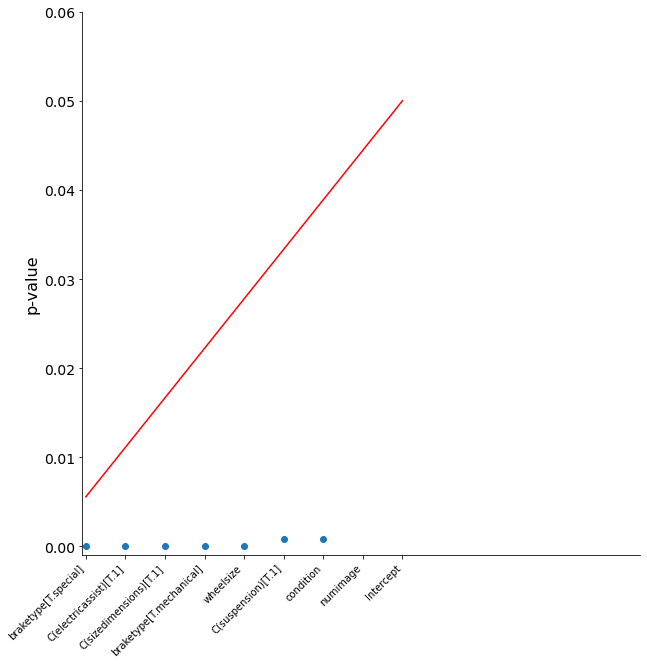

In [355]:
final_model = smf.ols(' price ~ + ' + ' + '.join(corr_candidates), data=df).fit()
df_p_values = final_model.summary2().tables[1].sort_values('P>|t|', ascending = True)
#df_p_values = df_p_values[df_p_values['P>|t|']<0.05]
n_vars = len(df_p_values)

plt.figure(figsize=(10, 10))

plt.plot(range(1, n_vars+1), df_p_values['P>|t|'], linewidth=0, marker='o')
plt.plot(range(1, n_vars+1), [0.05*i/n_vars for i in range(1, n_vars+1)], color='red')

plt.ylim([-0.001, 0.06])
plt.xlim([0.9, 15])

plt.xticks(ticks=range(1, n_vars+1), labels=df_p_values.index, rotation=45, ha='right')
plt.yticks(fontsize=14)

plt.ylabel('p-value', fontsize=16)

sns.despine()

In [356]:
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     107.5
Date:                Wed, 27 Apr 2022   Prob (F-statistic):           1.05e-87
Time:                        11:57:09   Log-Likelihood:                -3074.4
No. Observations:                 406   AIC:                             6165.
Df Residuals:                     398   BIC:                             6197.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                -209.7346    264.433     -0.793      0.428    -729.595     310.126
C(electricassist)[T.1]    833.1477     72.798     11.445      0.000     690.031     976.265
braketype[T.mechanical]  -561.5331     80.236     -6.999      0.000    -719.272    -403.794
braketype[T.special]     -848.8986     68.118    -12.462      0.000    -982.815    -714.982
C(suspension)[T.1]       -185.3106     54.730     -3.386      0.001    -292.906     -77.716
C(sizedimensions)[T.1]    5.08e-13   6.38e-14      7.961      0.000    3.83e-13    6.33e-13
numimage                    6.7910      3.996      1.700      0.090      -1.064      14.646
condition                 170.8658     50.808      3.363      0.001      70.981     270.751
wheelsize                  33.2479      6.857      4.848      0.000      19.766      46.729
==============================================================================
Omnibus:                       87.846   Durbin-Watson:                   1.783
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              203.342
Skew:                           1.092   Prob(JB):                     7.00e-45
Kurtosis:                       5.693   Cond. No.                     2.54e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.69e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [357]:
final_model.summary2().tables[1].sort_values('P>|t|').round(3)

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
braketype[T.special],-848.899,68.118,-12.462,0.000,-982.815,-714.982
C(electricassist)[T.1],833.148,72.798,11.445,0.000,690.031,976.265
C(sizedimensions)[T.1],0.000,0.000,7.961,0.000,0.000,0.000
braketype[T.mechanical],-561.533,80.236,-6.999,0.000,-719.272,-403.794
wheelsize,33.248,6.857,4.848,0.000,19.766,46.729
C(suspension)[T.1],-185.311,54.730,-3.386,0.001,-292.906,-77.716
condition,170.866,50.808,3.363,0.001,70.981,270.751
numimage,6.791,3.996,1.700,0.090,-1.064,14.646
Intercept,-209.735,264.433,-0.793,0.428,-729.595,310.126


In [358]:
all_var_model = smf.ols(' price ~ + ' + ' + '.join(corr_important_attributes), data=df).fit()
all_var_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     42.36
Date:                Wed, 27 Apr 2022   Prob (F-statistic):           4.83e-83
Time:                        11:57:11   Log-Likelihood:                -2450.1
No. Observations:                 334   AIC:                             4950.
Df Residuals:                     309   BIC:                             5045.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                             -442.2156    336.883     -1.313      0.190   -1105.090     220.659
bicycleframematerial[T.aluminum]      -147.7977     66.654     -2.217      0.027    -278.951     -16.644
bicycleframematerial[T.carbon fiber]   644.0593    103.528      6.221      0.000     440.350     847.769
bicycleframematerial[T.composite]     -190.3589    414.750     -0.459      0.647   -1006.450     625.733
bicycleframematerial[T.scandium]      2.426e-13   2.77e-13      0.876      0.382   -3.02e-13    7.87e-13
bicycleframematerial[T.steel]         -158.1022     75.486     -2.094      0.037    -306.633      -9.571
bicycleframematerial[T.titanium]      -148.1246    244.588     -0.606      0.545    -629.393     333.144
bicycletype[T.cargo/pedicab]          1165.6889    403.454      2.889      0.004     371.823    1959.555
bicycletype[T.cruiser]                -213.5632     94.325     -2.264      0.024    -399.164     -27.963
bicycletype[T.cyclocross]               83.4834    208.094      0.401      0.689    -325.978     492.944
bicycletype[T.folding]                 -17.2978    175.039     -0.099      0.921    -361.718     327.122
bicycletype[T.gravel]                 -156.8211    154.426     -1.016      0.311    -460.681     147.039
bicycletype[T.hybrid/comfort]         -219.6657    102.901     -2.135      0.034    -422.141     -17.190
bicycletype[T.kids]                    -52.6886    131.516     -0.401      0.689    -311.469     206.092
bicycletype[T.mountain]                -88.5323     98.046     -0.903      0.367    -281.455     104.390
bicycletype[T.recumbent/trike]         519.1503    289.089      1.796      0.074     -49.681    1087.981
bicycletype[T.road]                   -130.8242     89.102     -1.468      0.143    -306.148      44.500
bicycletype[T.tandem]                  328.0721    235.748      1.392      0.165    -135.802     791.946
bicycletype[T.track]                  2.577e-13   9.98e-14      2.581      0.010    6.12e-14    4.54e-13
bicycletype[T.unicycle]              -3.868e-13   2.01e-13     -1.928      0.055   -7.82e-13    7.93e-15
braketype[T.mechanical]               -471.9754     77.530     -6.088      0.000    -624.528    -319.423
braketype[T.special]                  -761.1698     69.834    -10.900      0.000    -898.580    -623.760
C(electricassist)[T.1]                 822.6256     76.424     10.764      0.000     672.249     973.002
C(suspension)[T.1]                    -232.4238     69.163     -3.361      0.001    -368.515     -96.333
C(sizedimensions)[T.1]                3.743e-14   2.41e-14      1.556      0.121   -9.92e-15    8.48e-14
numimage                                10.3956      4.018      2.587      0.010       2.489      18.302
condition                             

In [359]:
all_var_model.summary2().tables[1].sort_values('P>|t|').round(3)

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
braketype[T.special],-761.170,69.834,-10.900,0.000,-898.580,-623.760
C(electricassist)[T.1],822.626,76.424,10.764,0.000,672.249,973.002
bicycleframematerial[T.carbon fiber],644.059,103.528,6.221,0.000,440.350,847.769
braketype[T.mechanical],-471.975,77.530,-6.088,0.000,-624.528,-319.423
wheelsize,48.892,9.819,4.979,0.000,29.571,68.213
condition,177.365,47.348,3.746,0.000,84.201,270.530
C(suspension)[T.1],-232.424,69.163,-3.361,0.001,-368.515,-96.333
bicycletype[T.cargo/pedicab],1165.689,403.454,2.889,0.004,371.823,1959.555
numimage,10.396,4.018,2.587,0.010,2.489,18.302
bicycletype[T.track],0.000,0.000,2.581,0.010,0.000,0.000


## Feature selection for prediction: Adjusted R²

In [360]:
#Let's first use our step-wise forward selection regression

candidates = []
last_max = -1

y = 'price'

while(True):
    dict_r2 = dict()
    for x in df.drop([y] + candidates, axis=1).columns:
        if len(candidates) == 0:
            features = x
        else:
            if df.dtypes[x]==int:
                features = 'C('+ x + ')' + ' + '
            else: 
                features = x + ' + '
            features += ' + '.join(candidates)

        model = smf.ols(y + ' ~ ' + features, df).fit()
        dict_r2[x] = 1-((1-model.rsquared)*(len(df)-1)/(len(df)-len(candidates)-1-1))

    max_dict_r2 =  max(dict_r2.values())
    max_dict_r2_key = max(dict_r2, key=dict_r2.get)

    if max_dict_r2 > last_max:
        candidates.append(max_dict_r2_key)
        last_max = max_dict_r2

        print('Added features: ', candidates )
        print('Adjusted R2: ' + str(max_dict_r2))
        print('***')
    else:
        break

print('\n\n')
print('elminated variables: ')
print(set(df.drop(y, axis=1).columns).difference(candidates))

Added features:  ['braketype']
Adjusted R2: 0.48238342369169185
***
Added features:  ['braketype', 'bicycletype']
Adjusted R2: 0.5731662920326043
***
Added features:  ['braketype', 'bicycletype', 'numimage']
Adjusted R2: 0.6009467572875204
***
Added features:  ['braketype', 'bicycletype', 'numimage', 'electricassist']
Adjusted R2: 0.6276987134188676
***
Added features:  ['braketype', 'bicycletype', 'numimage', 'electricassist', 'bicycleframematerial']
Adjusted R2: 0.66875063136029
***
Added features:  ['braketype', 'bicycletype', 'numimage', 'electricassist', 'bicycleframematerial', 'handlebartype']
Adjusted R2: 0.7276287025460503
***
Added features:  ['braketype', 'bicycletype', 'numimage', 'electricassist', 'bicycleframematerial', 'handlebartype', 'wheelsize']
Adjusted R2: 0.7426683677581047
***
Added features:  ['braketype', 'bicycletype', 'numimage', 'electricassist', 'bicycleframematerial', 'handlebartype', 'wheelsize', 'condition']
Adjusted R2: 0.7537592184604895
***
Added featur

In [361]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     42.36
Date:                Wed, 27 Apr 2022   Prob (F-statistic):           4.83e-83
Time:                        11:57:19   Log-Likelihood:                -2450.1
No. Observations:                 334   AIC:                             4950.
Df Residuals:                     309   BIC:                             5045.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                             -442.2156    336.883     -1.313      0.190   -1105.090     220.659
braketype[T.mechanical]               -471.9754     77.530     -6.088      0.000    -624.528    -319.423
braketype[T.special]                  -761.1698     69.834    -10.900      0.000    -898.580    -623.760
bicycletype[T.cargo/pedicab]          1165.6889    403.454      2.889      0.004     371.823    1959.555
bicycletype[T.cruiser]                -213.5632     94.325     -2.264      0.024    -399.164     -27.963
bicycletype[T.cyclocross]               83.4834    208.094      0.401      0.689    -325.978     492.944
bicycletype[T.folding]                 -17.2978    175.039     -0.099      0.921    -361.718     327.122
bicycletype[T.gravel]                 -156.8211    154.426     -1.016      0.311    -460.681     147.039
bicycletype[T.hybrid/comfort]         -219.6657    102.901     -2.135      0.034    -422.141     -17.190
bicycletype[T.kids]                    -52.6886    131.516     -0.401      0.689    -311.469     206.092
bicycletype[T.mountain]                -88.5323     98.046     -0.903      0.367    -281.455     104.390
bicycletype[T.recumbent/trike]         519.1503    289.089      1.796      0.074     -49.681    1087.981
bicycletype[T.road]                   -130.8242     89.102     -1.468      0.143    -306.148      44.500
bicycletype[T.tandem]                  328.0721    235.748      1.392      0.165    -135.802     791.946
bicycletype[T.track]                  -3.19e-13   8.55e-14     -3.730      0.000   -4.87e-13   -1.51e-13
bicycletype[T.unicycle]               1.234e-13   7.53e-14      1.638      0.102   -2.48e-14    2.72e-13
bicycleframematerial[T.aluminum]      -147.7977     66.654     -2.217      0.027    -278.951     -16.644
bicycleframematerial[T.carbon fiber]   644.0593    103.528      6.221      0.000     440.350     847.769
bicycleframematerial[T.composite]     -190.3589    414.750     -0.459      0.647   -1006.450     625.733
bicycleframematerial[T.scandium]     -8.517e-14   8.21e-14     -1.037      0.301   -2.47e-13    7.64e-14
bicycleframematerial[T.steel]         -158.1022     75.486     -2.094      0.037    -306.633      -9.571
bicycleframematerial[T.titanium]      -148.1246    244.588     -0.606      0.545    -629.393     333.144
sizedimensions                        2.983e-14   3.36e-14      0.887      0.376   -3.63e-14     9.6e-14
numimage                                10.3956      4.018      2.587      0.010       2.489      18.302
electricassist                         822.6256     76.424     10.764      0.000     672.249     973.002
wheelsize                               48.8918      9.819      4.979      0.000      29.571      68.213
condition                             

In [362]:
corr_candidates = categorical_attributes(candidates)
corr_candidates

['braketype',
 'bicycletype',
 'numimage',
 'C(electricassist)',
 'bicycleframematerial',
 'handlebartype',
 'wheelsize',
 'condition',
 'framesize',
 'C(suspension)']

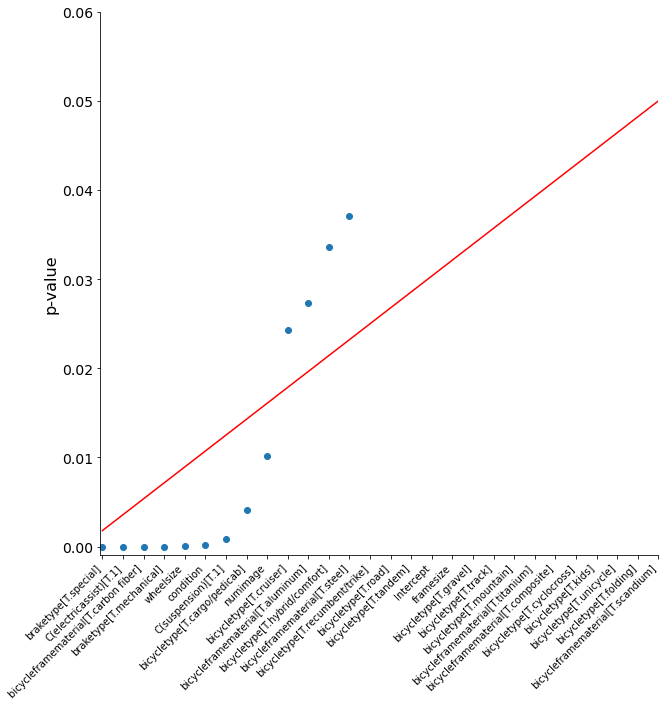

In [363]:
#Let's use the Benjamini Hochberg procedure to keep only significant variables

final_model = smf.ols(' price ~ + ' + ' + '.join(corr_candidates), data=df).fit()
df_p_values = final_model.summary2().tables[1].sort_values('P>|t|', ascending = True)
#df_p_values = df_p_values[df_p_values['P>|t|']<0.05]
n_vars = len(df_p_values)

plt.figure(figsize=(10, 10))

plt.plot(range(1, n_vars+1), df_p_values['P>|t|'], linewidth=0, marker='o')
plt.plot(range(1, n_vars+1), [0.05*i/n_vars for i in range(1, n_vars+1)], color='red')

plt.ylim([-0.001, 0.06])
plt.xlim([0.9, 15])

plt.xticks(ticks=range(1, n_vars+1), labels=df_p_values.index, rotation=45, ha='right')
plt.yticks(fontsize=14)

plt.ylabel('p-value', fontsize=16)

sns.despine()

In [364]:
df_p_values.index[:9]

Index(['braketype[T.special]', 'C(electricassist)[T.1]',
       'bicycleframematerial[T.carbon fiber]', 'braketype[T.mechanical]',
       'wheelsize', 'condition', 'C(suspension)[T.1]',
       'bicycletype[T.cargo/pedicab]', 'numimage'],
      dtype='object')

In [365]:
#Let's compute the adjusted R2 if we continued to add more variables

number_variables = []
R2_list = []
candidates = []
last_max = -1

y = 'price'

while(len(candidates)<len(df.columns)-1):
    dict_r2 = dict()
    for x in df.drop([y] + candidates, axis=1).columns:
        if len(candidates) == 0:
            features = x
        else:
            if df.dtypes[x]==int:
                features = 'C('+ x + ')' + ' + '
            else: 
                features = x + ' + '
            features += ' + '.join(candidates)

        model = smf.ols(y + ' ~ ' + features, df).fit()
        dict_r2[x] = 1-((1-model.rsquared)*(len(df)-1)/(len(df)-len(candidates)-2))

    max_dict_r2 =  max(dict_r2.values())
    max_dict_r2_key = max(dict_r2, key=dict_r2.get)

    if max_dict_r2 > last_max or max_dict_r2 <= last_max:
        candidates.append(max_dict_r2_key)
        last_max = max_dict_r2

        number_variables.append(len(candidates))
        R2_list.append(max_dict_r2)
    else:
        break

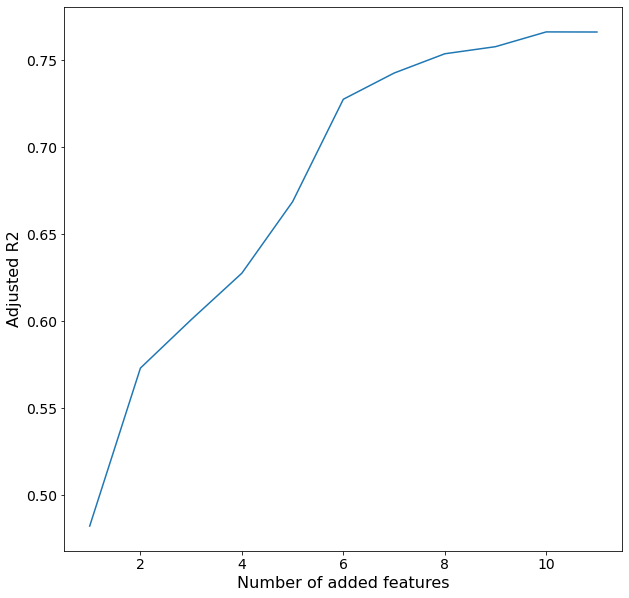

<Figure size 432x288 with 0 Axes>

In [366]:
#Let's plot the evolution of the adjusted R2

plt.figure(figsize=(10, 10))
plt.plot(number_variables, R2_list)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Number of added features', fontsize=16)
plt.ylabel('Adjusted R2', fontsize=16)
plt.show()

sns.despine()

In [367]:
df.to_csv('preprocessed_data_craigslist.csv')